<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/EuroSat_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is used to train the baseline for the EuroSAT model.

The code is based on the EuroSAT_Pytorch.ipynb from this repository: https://github.com/ahmadmughees/EuroSat-PyTorch


**Importing** **Libraries**

In [ ]:
#Importing Libraries
from skimage import io
import torch
from torchvision import models
import torchvision
import torch.nn as nn
import numpy as np
import random
from IPython.display import clear_output
import time
import os.path
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split

In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EuroSat_Type = 'ALL'    # use 'RGB' or 'ALL' for type of Eurosat Dataset. Just change in this line. Rest of the code is managed for both type
lr = 0.001               # learn_rate
milestones = [50,75,90] # multistep scheduler
epochs = 1000            # no of epochs

In [ ]:
def iloader(path):
    image = np.asarray((io.imread(path))/5000,dtype='float32') # to understand why the 5000, check the histogram in the methodology dataset section of the thesis
    return image.transpose(2,0,1)

## use the mean and std in the transformation and actually get the dataloaders

In [ ]:
root = '/content/drive/MyDrive/baseline_dataset/'

class CustomToTensor(object):
    """Convert a PIL Image or numpy.ndarray to tensor.
    Converts image to dtype=torch.float32 and scales the image's pixel values to [0, 1].
    """
    def __call__(self, pic):
        # Convert PIL Image to NumPy array
        if isinstance(pic, Image.Image):
            img = np.array(pic)
        elif isinstance(pic, np.ndarray):
            img = pic
        else:
            raise TypeError("Input pic must be a PIL Image or numpy.ndarray.")

        # If the image array type is not float, convert it to float
        if img.dtype != np.float32:
            img = img.astype(np.float32)

        # Convert image to PyTorch tensor
        img_tensor = torch.from_numpy(img)

        return img_tensor

# Define the transformations
transform = transforms.Compose([
    CustomToTensor(),
    #transforms.Resize(224) # resize to better work wih resnet18
    transforms.Normalize([0.2703, 0.2232, 0.2084, 0.1894, 0.2401, 0.4013, 0.4757, 0.4612, 0.1468,
         0.0024, 0.3646, 0.2237, 0.5209], [0.0484, 0.0663, 0.0787, 0.1184, 0.1126, 0.1717, 0.2170, 0.2235, 0.0811,
         0.0009, 0.2001, 0.1517, 0.2461])  # Normalize the image
])

In [ ]:
def load_data():
    loader_function = iloader  # Make sure iloader is defined correctly

    # Load the dataset
    dataset = torchvision.datasets.DatasetFolder(root=root, loader=loader_function, transform=transform, extensions='tif')

    # Get indices for all data points and their corresponding targets
    indices = list(range(len(dataset)))
    targets = [dataset.samples[i][1] for i in indices]

    # First split: train and temporary (which will be further split into validation and test)
    train_indices, temp_indices = train_test_split(indices, test_size=0.3, stratify=targets, random_state=42)

    # Targets for the temp set
    temp_targets = [targets[i] for i in temp_indices]

    # Second split: temp into validation and test
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, stratify=temp_targets, random_state=42)

    # Create Subset instances
    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    test_set = Subset(dataset, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=16, shuffle=False, drop_last=True)

    return dataset, train_loader, val_loader, test_loader

# Now you can call load_data to get your data loaders with properly stratified splits.

In [ ]:
dataset_all, train_loader, val_loader, test_loader = load_data()

**Functions for Augmentation**

In [ ]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def cus_aug(data):
  """
  randomly rotate and randomly flip
  """
    data = torch.rot90(data,random.randint(-3,3), dims=random.choice([[3,2],[2,3]]))
    if random.random()>0.5:
        data = torch.flip(data, dims = random.choice([[2,],[3,],[2,3]]))
    #pixmis = torch.empty_like(data).random_(data.shape[-1])
    #pixmis = torch.where(pixmis>(data.shape[-1]/8),torch.ones_like(data),torch.zeros_like(data))
    return data#* pixmis

In [ ]:
def Load_model():
  """
  load a resnet18 model, and change the number of output channels to 10, and make the first convolution take in the 13 multispectral bands
  """
    model_ft = models.resnet18()#pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 10)
    inBands = 13
    model_ft.conv1 = nn.Conv2d(inBands, 64, kernel_size=7, stride=2, padding = 3, bias = False)
    print('Model Loaded')
    return model_ft

In [ ]:
def accuracy(gt_S,pred_S):
    _, alp = torch.max(torch.from_numpy(pred_S), 1)
    return accuracy_score(gt_S,np.asarray(alp))#np.mean(F1score)

In [ ]:
def F1_score(gt_S, pred_S):
  _, pred = torch.max(torch.from_numpy(pred_S),1)
  f1 = f1_score(gt_S, np.asarray(pred), average='macro')
  return f1

In [ ]:
def validation(model, val_,):
    model.eval()
    #tot_acc=[]
    test_iter=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_):
            print(batch_idx)
            data, target = cus_aug(Variable(data.cuda())), Variable(target.cuda())
            output = model(data)
            _, pred = torch.max(output, 1)
            pred = output.data.cpu().numpy()
            gt = target.data.cpu().numpy()
            if test_iter==0:
                all_pred=pred
                all_gt=gt
            else:
                all_pred=np.vstack((all_pred,pred))
                all_gt  =np.vstack((all_gt,gt))

            test_iter=test_iter+1
        acc=accuracy(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
        f1 = F1_score(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
        model.train()
        return acc, f1#,cm

In [ ]:
def train(net, train_, val_, criterion, optimizer, epochs=None, scheduler=None, weights=None, save_epoch = 10):
    # losses=[]; acc=[]; mean_losses=[]; val_acc=[]
    # iter_ = t0 =0
    # for e in tqdm(range(1, epochs + 1)):
    #     net.train()
    #     for batch_idx, (data, target) in enumerate(tqdm(train_)):
    #         data, target =  cus_aug(data.cuda()), target.cuda()
    #         optimizer.zero_grad()
    #         output = net(data)
    #         loss = criterion(output, target)
    #         loss.backward()
    #         optimizer.step()
    #         losses.append(loss.item())
    #         mean_losses.append(np.mean(losses[max(0,iter_-100):iter_]))
    #         if iter_ % 2 == 0: #printing after 2 epochs
    #             #clear_output()
    #             print('Iteration Number',iter_,'{} seconds'.format(time.time() - t0))
    #             t0 = time.time()
    #             pred = output.data.cpu().numpy()#[0]
    #             pred=sigmoid(pred)
    #             gt = target.data.cpu().numpy()#[0]
    #             acc.append(accuracy(gt,pred))
    #             print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
    #                 e, epochs, batch_idx, len(train_),
    #                 100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))
    #             plt.plot(mean_losses) and plt.show()
    #             val_acc.append(validation(net, val_))
    #             print('validation accuracy : {}'.format(val_acc[-1]))
    #             plt.plot( range(len(acc)) ,acc,'b',label = 'training')
    #             plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
    #             plt.legend() and plt.show()
    #             #print(mylabels[np.where(gt[1,:])[0]])
    #         iter_ += 1

    #         del(data, target, loss)
    #     if scheduler is not None:
    #        scheduler.step()
    #     if e % save_epoch == 0:
    #         save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_eurosat/'
    #         #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    #         save_path = save_base_path + '{}_{}.cp'.format(RUNNAME, e)
    #         torch.save(net.state_dict(), save_path)

    losses, acc, f1s , mean_losses, val_acc, val_f1 = [], [], [], [], [], []
    iter_, t0 = 0, time.time()

    for e in tqdm(range(1, epochs + 1), desc="Epochs"):
        net.train()
        for batch_idx, (data, target) in enumerate(tqdm(train_, desc="Training", leave=False)):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            mean_losses.append(np.mean(losses[max(0, iter_ - 100):]))

            if iter_ % 10 == 0:
                print(f'Iteration Number {iter_}, Time elapsed: {time.time() - t0:.2f} seconds')
                t0 = time.time()
                pred = sigmoid(output.data.cpu().numpy())
                _, alp = torch.max(torch.from_numpy(pred), 1)
                gt = target.data.cpu().numpy()
                acc.append(accuracy(gt, pred))
                f1s.append(F1_score(gt,pred))
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\ty_true:{}\ty_pred:{}\tLearning Rate:{}'.format(
                    e, epochs, batch_idx, len(train_),
                    100. * batch_idx / len(train_), loss.item(), acc[-1], gt, alp, optimizer.param_groups[0]['lr']))
                #plt.plot(mean_losses) and plt.show()
                # val_acc.append(validation(net, val_))
                # print('validation accuracy : {}'.format(val_acc[-1]))
                # plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                # plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                #plt.legend() and plt.show()
                #plt.show()

            if iter_ % 395 == 0 and iter_ != 0:
                clear_output()
                plt.plot(mean_losses) and plt.show()
                val_accuracy, val_f1score = validation(net, val_)
                val_acc.append(val_accuracy)
                val_f1.append(val_f1score)
                print('validation accuracy : {}'.format(val_acc[-1]))
                print('validation F1 : {}'.format(val_f1[-1]))
                plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                plt.legend() and plt.show()
                plt.show()
                save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_eurosat/'
                #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
                save_path = save_base_path + '{}_{}.cp'.format(RUNNAME, iter_)
                torch.save(net.state_dict(), save_path)

            iter_ += 1

        if scheduler is not None:
            scheduler.step()

        # if e % save_epoch == 0:
        #     save_path = f'/path/to/save/models/epoch_{e}.pth'
        #     torch.save(net.state_dict(), save_path)
    return net, val_accuracy, val_f1, acc, f1s

In [ ]:
net = Load_model()
criteria = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

Model Loaded


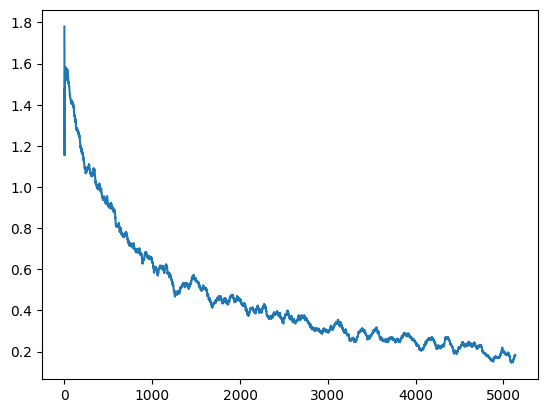

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
validation accuracy : 0.8348214285714286
validation F1 : 0.8301812963182089


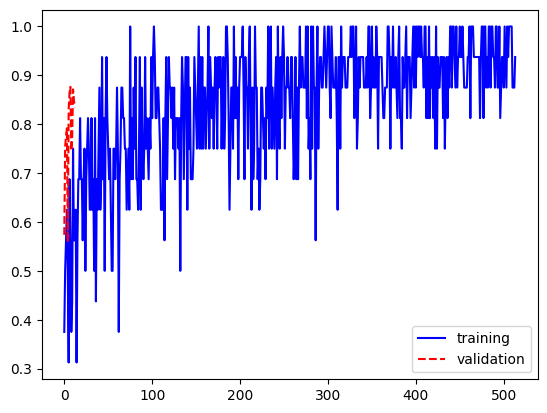

Iteration Number 5140, Time elapsed: 7.17 seconds
Train (epoch 14/15) [5/395 (1%)]	Loss: 0.205368	Accuracy: 0.8125	y_true:[4 6 9 2 2 7 1 7 5 3 1 7 7 9 5 2]	y_pred:tensor([4, 0, 9, 2, 2, 7, 1, 7, 5, 0, 1, 7, 3, 9, 5, 2])	Learning Rate:0.001
Iteration Number 5150, Time elapsed: 0.96 seconds
Train (epoch 14/15) [15/395 (4%)]	Loss: 0.036442	Accuracy: 1.0	y_true:[3 2 1 7 9 2 7 4 6 6 2 3 0 6 4 2]	y_pred:tensor([3, 2, 1, 7, 9, 2, 7, 4, 6, 6, 2, 3, 0, 6, 4, 2])	Learning Rate:0.001
Iteration Number 5160, Time elapsed: 0.98 seconds
Train (epoch 14/15) [25/395 (6%)]	Loss: 0.076654	Accuracy: 1.0	y_true:[8 6 7 1 3 0 1 4 4 0 1 6 1 7 2 0]	y_pred:tensor([8, 6, 7, 1, 3, 0, 1, 4, 4, 0, 1, 6, 1, 7, 2, 0])	Learning Rate:0.001
Iteration Number 5170, Time elapsed: 0.99 seconds
Train (epoch 14/15) [35/395 (9%)]	Loss: 0.042910	Accuracy: 1.0	y_true:[7 6 9 0 1 5 7 9 2 5 2 2 6 3 8 1]	y_pred:tensor([7, 6, 9, 0, 1, 5, 7, 9, 2, 5, 2, 2, 6, 3, 8, 1])	Learning Rate:0.001
Iteration Number 5180, Time elapsed: 0.94 seco

KeyboardInterrupt: 

In [ ]:
# actually train
from tqdm.notebook import tqdm

RUNNAME = 'baseline_LR0.001_honest_final_second_try_eurosat'

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

net = net.cuda()
net, val_acc, val_f1, acc, f1s = train(net, train_loader, val_loader, criteria, optimizer, 15, scheduler)

In [ ]:
import json
with open(f'/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_eurosat/{RUNNAME}.json', 'w') as f:
        json.dump({'val_acc': val_acc,
                  'val_f1': val_f1,
                  'acc': acc,
                  'f1s': f1s}, f)

In [ ]:
test_acc, test_f1 = validation(net, test_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


In [ ]:
test_acc, test_f1

(0.8980654761904762, 0.8933642381183556)